In [1]:
! pip install statsforecast mlforecast hierarchicalforecast

  Obtaining dependency information for statsforecast from https://files.pythonhosted.org/packages/f0/c5/ed81d179271f2c5ed51eab47aff164fc4f125d695ef582902c65ac8b8a01/statsforecast-1.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for mlforecast from https://files.pythonhosted.org/packages/2d/06/8b6ebd2be93a27b75a380af363156d52aad5b77929f65d9bd5a958ef894b/mlforecast-0.11.3-py3-none-any.whl.metadata
  Obtaining dependency information for hierarchicalforecast from https://files.pythonhosted.org/packages/df/c3/11a2b8936c4c6d867dcc591378bfc1422bd7265dab3193a0a7e190f1afbb/hierarchicalforecast-0.4.1-py3-none-any.whl.metadata
  Obtaining dependency information for fugue>=0.8.1 from https://files.pythonhosted.org/packages/ae/47/d3449da0b9cad85a361bc1003554710a5b612cf60bc2840096e93e5cdbb3/fugue-0.8.7-py3-none-any.whl.metadata
  Obtaining dependency information for utilsforecast>=0.0.22 from https://files.pythonhosted.org/packages/c2/2f/081f25988926ae4bbc516e9830bbad5c0fe28ea593f0

In [11]:
data_dir = '/kaggle/input/project3-data/project_3_data/project_3_data/'

## Hierarchical Forecasting

In [3]:
# add imports

import pandas as pd
import numpy as np

We're going to start by building a model at the store-deparment level. Our goal is to create a forecast at that level that coherently aggregates up to the state level.

In [12]:
data = (
    pd.read_parquet(f'{data_dir}/sales_data.parquet')
    .reset_index()
    .rename(columns={'date': 'ds', 'sales': 'y'})
    .assign(store_dept_id=lambda df: df.store_id + '_' + df.dept_id)
    .groupby(['ds', 'store_dept_id', 'store_id', 'state_id'])
    .y
    .sum()
    .reset_index()
)
data.head()

,ds,store_dept_id,store_id,state_id,y
0,2013-01-01,TX_1_FOODS_1,TX_1,TX,195
1,2013-01-01,TX_1_FOODS_2,TX_1,TX,271
2,2013-01-01,TX_1_FOODS_3,TX_1,TX,1141
3,2013-01-01,TX_1_HOBBIES_1,TX_1,TX,83
4,2013-01-01,TX_1_HOBBIES_2,TX_1,TX,11


Now it's time to set up our hierarchical data. Use the `aggregate` method from `hierarchicalforecast` to hierarchically structure our data and get the proper summing dataframe.

In [28]:
from hierarchicalforecast.utils import aggregate

# this is the `spec` argument in the `aggregate` function
hierarchy_levels = [['state_id'],
                    ['state_id', 'store_id'],
                    ['state_id', 'store_id', 'store_dept_id']]
y_hier, S_df, tags = aggregate(df=data, spec=hierarchy_levels)
y_hier = y_hier.reset_index()

In [30]:
y_hier.tail()

,unique_id,ds,y
30945,TX/TX_3/TX_3_HOUSEHOLD_2,2016-05-18,157
30946,TX/TX_3/TX_3_HOUSEHOLD_2,2016-05-19,174
30947,TX/TX_3/TX_3_HOUSEHOLD_2,2016-05-20,202
30948,TX/TX_3/TX_3_HOUSEHOLD_2,2016-05-21,213
30949,TX/TX_3/TX_3_HOUSEHOLD_2,2016-05-22,220


In [22]:
y_hier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30950 entries, 0 to 30949
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  30950 non-null  object        
 1   ds         30950 non-null  datetime64[us]
 2   y          30950 non-null  int64         
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 725.5+ KB


In [20]:
S_df.head()

,TX/TX_1/TX_1_FOODS_1,TX/TX_1/TX_1_FOODS_2,TX/TX_1/TX_1_FOODS_3,TX/TX_1/TX_1_HOBBIES_1,TX/TX_1/TX_1_HOBBIES_2,TX/TX_1/TX_1_HOUSEHOLD_1,TX/TX_1/TX_1_HOUSEHOLD_2,TX/TX_2/TX_2_FOODS_1,TX/TX_2/TX_2_FOODS_2,TX/TX_2/TX_2_FOODS_3,...,TX/TX_2/TX_2_HOBBIES_2,TX/TX_2/TX_2_HOUSEHOLD_1,TX/TX_2/TX_2_HOUSEHOLD_2,TX/TX_3/TX_3_FOODS_1,TX/TX_3/TX_3_FOODS_2,TX/TX_3/TX_3_FOODS_3,TX/TX_3/TX_3_HOBBIES_1,TX/TX_3/TX_3_HOBBIES_2,TX/TX_3/TX_3_HOUSEHOLD_1,TX/TX_3/TX_3_HOUSEHOLD_2
TX,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
TX/TX_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TX/TX_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TX/TX_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
TX/TX_1/TX_1_FOODS_1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
tags

{'state_id': array(['TX'], dtype=object),
 'state_id/store_id': array(['TX/TX_1', 'TX/TX_2', 'TX/TX_3'], dtype=object),
 'state_id/store_id/store_dept_id': array(['TX/TX_1/TX_1_FOODS_1', 'TX/TX_1/TX_1_FOODS_2',
        'TX/TX_1/TX_1_FOODS_3', 'TX/TX_1/TX_1_HOBBIES_1',
        'TX/TX_1/TX_1_HOBBIES_2', 'TX/TX_1/TX_1_HOUSEHOLD_1',
        'TX/TX_1/TX_1_HOUSEHOLD_2', 'TX/TX_2/TX_2_FOODS_1',
        'TX/TX_2/TX_2_FOODS_2', 'TX/TX_2/TX_2_FOODS_3',
        'TX/TX_2/TX_2_HOBBIES_1', 'TX/TX_2/TX_2_HOBBIES_2',
        'TX/TX_2/TX_2_HOUSEHOLD_1', 'TX/TX_2/TX_2_HOUSEHOLD_2',
        'TX/TX_3/TX_3_FOODS_1', 'TX/TX_3/TX_3_FOODS_2',
        'TX/TX_3/TX_3_FOODS_3', 'TX/TX_3/TX_3_HOBBIES_1',
        'TX/TX_3/TX_3_HOBBIES_2', 'TX/TX_3/TX_3_HOUSEHOLD_1',
        'TX/TX_3/TX_3_HOUSEHOLD_2'], dtype=object)}

In [16]:
pred_df = (
    pd.read_parquet(f'/kaggle/input/project3-data/project_3_preds_sf_ets.parquet')
)
data.head()

,ds,store_dept_id,store_id,state_id,y
0,2013-01-01,TX_1_FOODS_1,TX_1,TX,195
1,2013-01-01,TX_1_FOODS_2,TX_1,TX,271
2,2013-01-01,TX_1_FOODS_3,TX_1,TX,1141
3,2013-01-01,TX_1_HOBBIES_1,TX_1,TX,83
4,2013-01-01,TX_1_HOBBIES_2,TX_1,TX,11


In [23]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85372 entries, 0 to 85371
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  85372 non-null  object        
 1   ds         85372 non-null  datetime64[us]
 2   AutoETS    85372 non-null  float32       
dtypes: datetime64[us](1), float32(1), object(1)
memory usage: 1.6+ MB


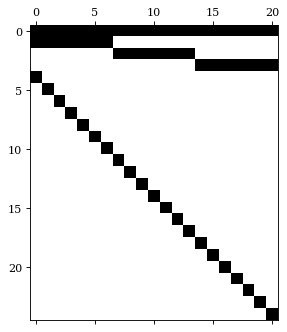

In [24]:
from hierarchicalforecast.utils import HierarchicalPlot

HierarchicalPlot(S_df, tags).plot_summing_matrix()

I went ahead and split your data for you. Train a `StatsForecast` model (any algorithm works, I used AutoARIMA). Be sure to grab the fitted values (i.e. the predictions on the training set), since we'll need that later.

In [26]:
val = y_hier.groupby('unique_id').tail(28)
train = y_hier.drop(val.index)

In [27]:
val.info()
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 1210 to 30949
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  700 non-null    object        
 1   ds         700 non-null    datetime64[us]
 2   y          700 non-null    int64         
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 21.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 30250 entries, 0 to 30921
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  30250 non-null  object        
 1   ds         30250 non-null  datetime64[us]
 2   y          30250 non-null  int64         
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 945.3+ KB


In [40]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, Naive

fcst = StatsForecast(df=train,
                     models=[AutoARIMA(season_length=4), Naive()],
                     freq='Q', n_jobs=-1)
# fcst = StatsForecast(models=[AutoARIMA(season_length=12)], freq='M')
y_fcst = fcst.forecast(h=28, fitted=True) # forecast on the validation period
y_fitted = fcst.forecast_fitted_values() # fitted values, i.e. forecast on the training data

Use the `StatsForecast.plot` method to visualize your predictions. Try passing `plot_random=False` to see how the model performs at the top levels.

In [42]:
y_fcst.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, TX to TX/TX_3/TX_3_HOUSEHOLD_2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         700 non-null    datetime64[ns]
 1   AutoARIMA  700 non-null    float32       
 2   Naive      700 non-null    float32       
dtypes: datetime64[ns](1), float32(2)
memory usage: 16.4+ KB


In [43]:
y_fitted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30250 entries, TX to TX/TX_3/TX_3_HOUSEHOLD_2
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         30250 non-null  datetime64[us]
 1   y          30250 non-null  float32       
 2   AutoARIMA  30250 non-null  float32       
 3   Naive      30225 non-null  float32       
dtypes: datetime64[us](1), float32(3)
memory usage: 827.1+ KB


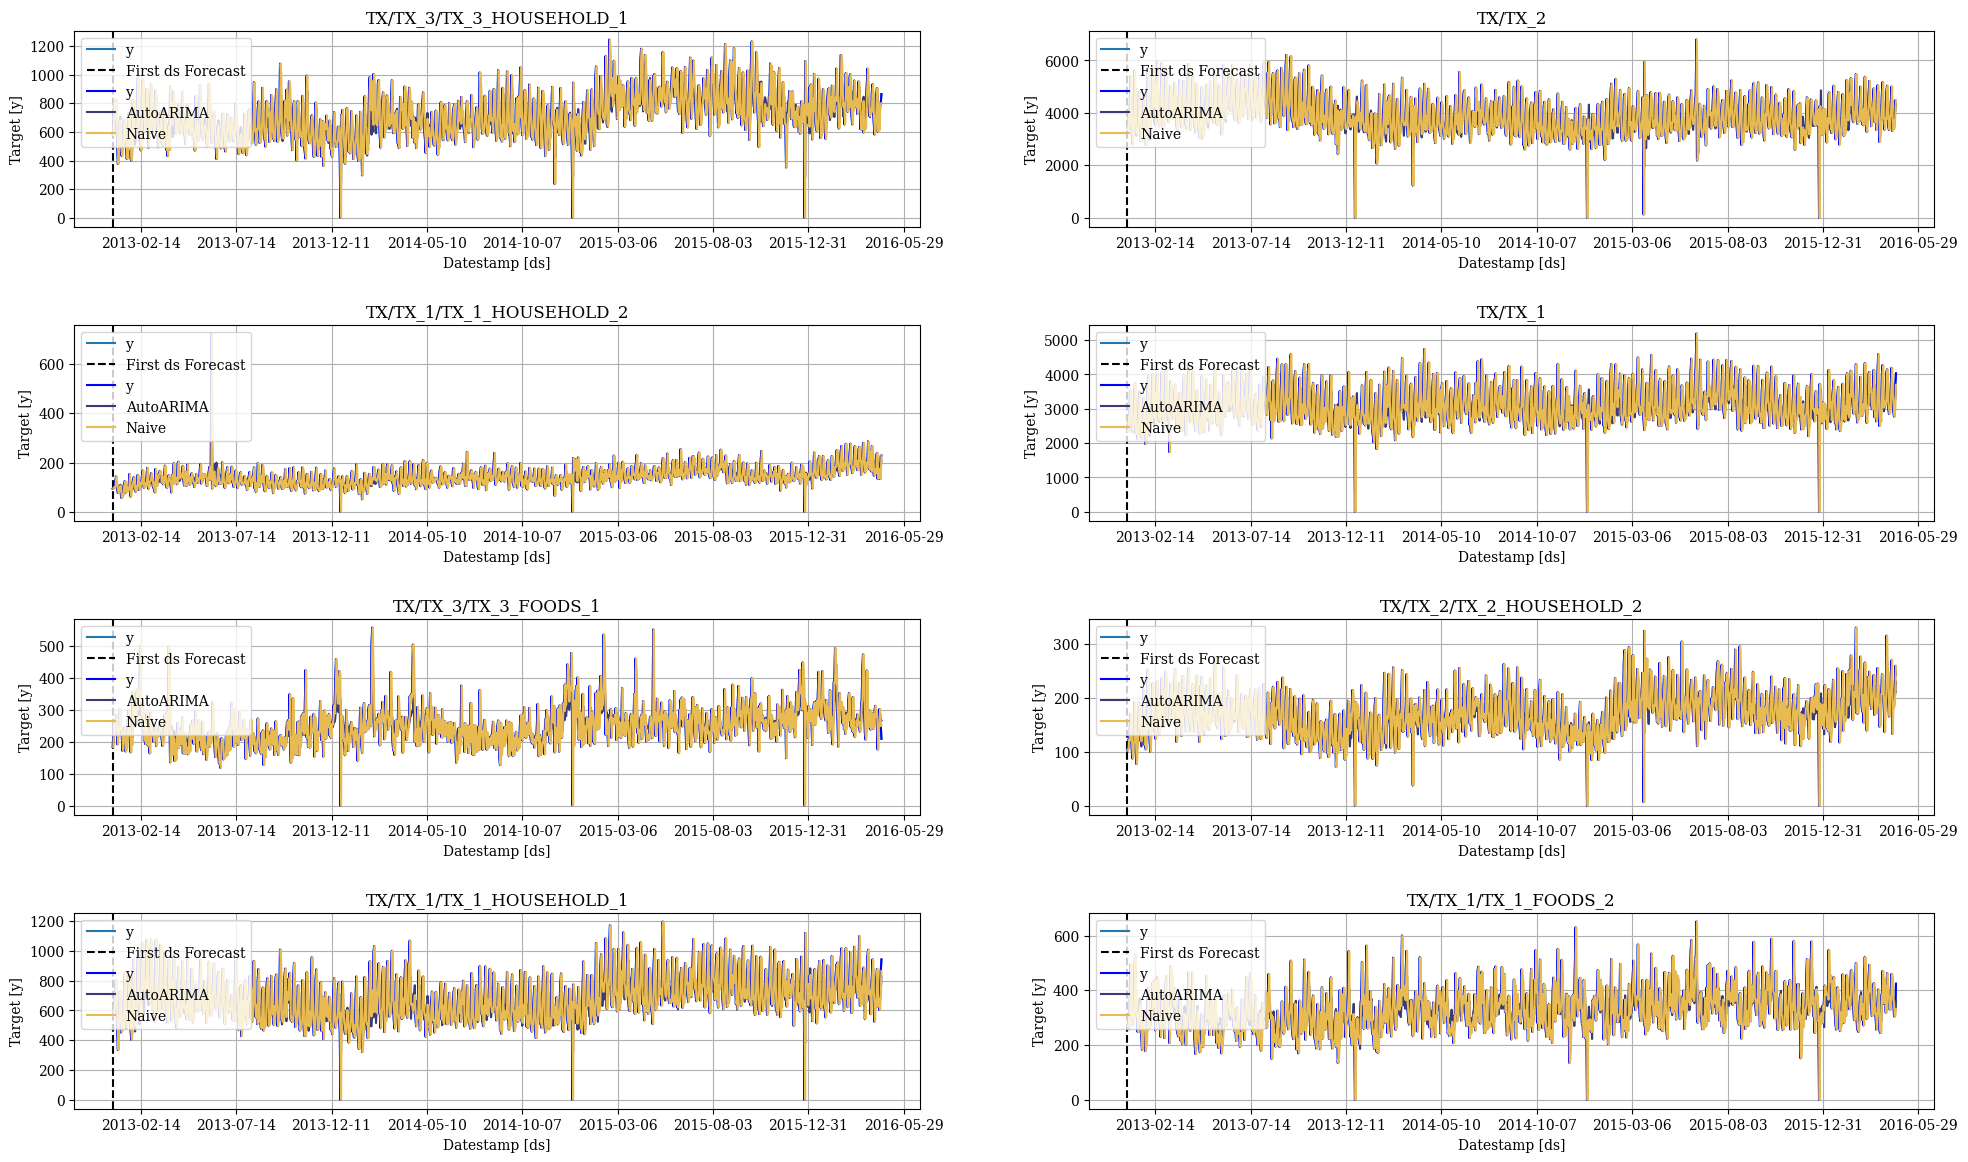

In [45]:
# statsforecast plots go here
StatsForecast.plot(train, y_fitted)

Now it's time to reconcile! Use the BottomUp, TopDown, and MinTrace reconciliation methods. For TopDown and MinTrace, try out the different methods provided by `hierarchicalforecast` to see which ones work best.

In [47]:
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MinTrace

reconcilers = [
    BottomUp(),
    TopDown(method='forecast_proportions'),
    # MiddleOut(middle_level='Country/Purpose/State',
      #        top_down_method='forecast_proportions')
]

hrec = HierarchicalReconciliation(reconcilers=reconcilers)

y_rec = hrec.reconcile(Y_hat_df=y_fcst, Y_df=train,
                          S=S_df, tags=tags)

y_rec.groupby('unique_id').head(2).head(10)

,ds,AutoARIMA,Naive,AutoARIMA/BottomUp,Naive/BottomUp,AutoARIMA/TopDown_method-forecast_proportions,Naive/TopDown_method-forecast_proportions
unique_id,,,,,,,
TX,2016-06-30,11723.127930,12282.0,11880.328125,12282.0,11723.127930,12282.000000
TX,2016-09-30,11243.699219,12282.0,10798.456055,12282.0,11243.699219,12282.000000
TX/TX_1,2016-06-30,3688.630127,4033.0,3734.419678,4033.0,3659.211914,4032.999756
TX/TX_1,2016-09-30,3358.354492,4033.0,3398.546875,4033.0,3472.346680,4032.999756
TX/TX_2,2016-06-30,4110.582031,4292.0,4229.210938,4292.0,4077.798584,4292.000000
TX/TX_2,2016-09-30,3788.065430,4292.0,3740.018066,4292.0,3916.643066,4292.000000
TX/TX_3,2016-06-30,4018.163818,3957.0,3916.697266,3957.0,3986.117432,3956.999756
TX/TX_3,2016-09-30,3728.164795,3957.0,3659.891602,3957.0,3854.709229,3956.999756
TX/TX_1/TX_1_FOODS_1,2016-06-30,210.722794,221.0,210.722794,221.0,206.479050,220.999985


Plot the results for your raw model predictions against the hierarchical predictions. How closely do the direct, non-hierarchical forecasts agree/disagree? What about the hierarchical forecasts?

Hint: the below plot shows a sample, but the answer to this question lies with `plot_hierarchical_predictions_gap()`. Check out some of the other plotting methods, too!

KeyError: "None of [Index(['TX'], dtype='object', name='unique_id')] are in the [index]"

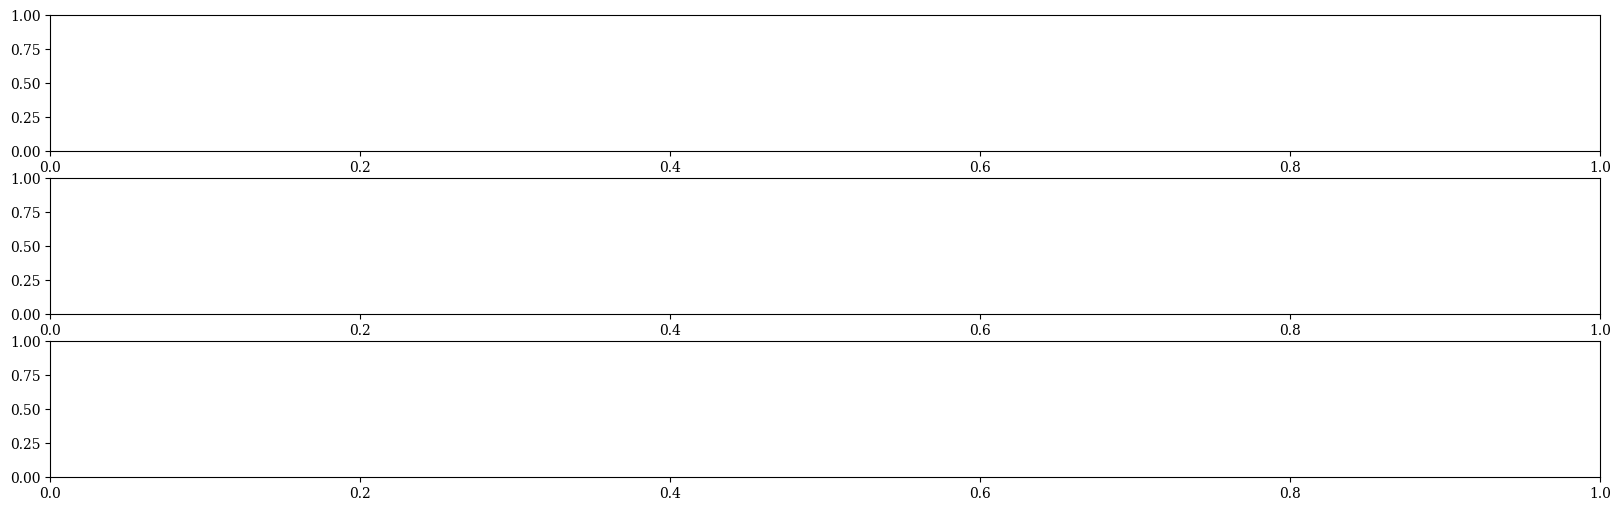

In [48]:
HierarchicalPlot(S_df, tags).plot_hierarchically_linked_series(
    bottom_series='TX/TX_3/TX_3_HOUSEHOLD_2',
    Y_df=val.merge(y_rec, on=['unique_id', 'ds']).set_index('unique_id'),
)

Use the helper code below to calculate RMSSE for every method you tried, at every level of the hierarchy. This code is borrowed and modified from the `hierarchicalforecast` library, because their implementation of `msse` is different than our version. This formulation of RMSSE should line up with the formulation from Project 2.

In [ ]:
from hierarchicalforecast.evaluation import HierarchicalEvaluation

def mse(y, y_hat, weights=None, axis=None):
    delta_y = np.square(y - y_hat)
    if weights is not None:
        mse = np.average(delta_y,
                         weights=weights,
                         axis=axis)
    else:
        mse = np.nanmean(delta_y, axis=axis)
    return mse

def rmsse(y, y_hat, y_insample, mask=None, insample_mask=None):
    if mask is None: 
       mask = np.ones_like(y)
       
    eps = np.finfo(float).eps

    norm = mse(y=y_insample[:, 1:], y_hat=y_insample[:, :-1], weights=insample_mask, axis=1)
    loss = mse(y=y, y_hat=y_hat, weights=mask, axis=1)

    loss = np.sqrt(loss / (norm + eps))
    return loss.mean()

HierarchicalEvaluation([rmsse]).evaluate(
    Y_hat_df=..., # your reconciled forecasts
    Y_test_df=..., # validation actuals DF, with unique_id as index
    tags=tags, # tags from aggregate()
    Y_df=... # training actuals DF, with unique_id as index
)

Answer the following questions:

- What's more accurate, the direct forecast, or the hierarchical methods?
- What's the most accurate method for top-level aggregation (i.e. the `state_id` level)?
- What's the most accurate method for bottom-level aggregation (i.e. the `state_id`/`store_id`/`store_dept_id` level)?

## Ensembling

Now, let's try to ensemble predictions from multiple models.

Below, fit two models -- one `mlforecast` model (could be the same one you used in Project 2), and one `statsforecast` model. You can fit the models at any level you want (just make sure both are fit at the same level), but I'd recommend trying out `item_id`. It's a little faster than at the `id` level, and it gives both models a good opportunity to show their diversity.

Once you've fit both models, be sure to plot some sample predictions.

Don't worry about tuning the performance much here. This is more about seeing ensembling in action than optimizing your individual models!

[Optional, if you have extra time] You can also fit a `neuralforecast` model.

In [ ]:
# read in a fresh copy of the data
data = (
    pd.read_parquet('data/sales_data.parquet')
    .reset_index()
    .groupby(['date', 'item_id', 'dept_id', 'cat_id'])
    .sales
    .sum()
    .reset_index()
    .assign(unique_id=lambda df: df.item_id.copy())
    .rename(columns={'date': 'ds', 'sales': 'y'})
)

In [ ]:
# fit an mlforecast model

from mlforecast import MLForecast

models = [
    ...
]

fcst = MLForecast(
    ...
)

fcst.fit(
    ...
)
preds_ml = fcst.predict(28)

In [ ]:
# fit a statsforecast model

from statsforecast.core import StatsForecast

fcst = StatsForecast(
    ...
)
# preds_sf = fcst.forecast(h=28).reset_index()

preds_sf = pd.read_parquet(...) # load in the saved predictions from the project data

Before starting to ensemble, let's check the RMSSE of our individual models. Our modified version of RMSSE takes predictions in a rectangular shape, with each row being one `unique_id` and each column being one of the 28 predictions for the validation set. That results in an array of shape `[n_unique_ids, 28]`. We need to do the same thing for the training data (`y_insample` here) to create the scale (the denominator). Finally, we create a mask to tell the RMSSE function not to calculate the scale value before each `unique_id` has its first sale, since we don't calculate the loss over those periods.

This code assumes you stored your `mlforecast` predictions in `preds_ml` and your `statsforecast` predictions in `preds_sf`.

Modify it to suit your needs!

In [ ]:
y = val.sort_values(['unique_id', 'ds']).y.values.reshape(-1, 28)
y_hat_ml = preds_ml.sort_values(['unique_id', 'ds']).LGBMRegressor.values.reshape(-1, 28)
y_hat_sf = preds_sf.sort_values(['unique_id', 'ds']).AutoETS.values.reshape(-1, 28)
y_insample = train.sort_values(['unique_id', 'ds']).y.values.reshape(-1, 1210)
insample_mask = (y_insample.cumsum(axis=1) > 0).astype(int)[:, 1:]

In [ ]:
print(f'LightGBM Tweedie RMSSE: {rmsse(y, y_hat_ml, y_insample, insample_mask=insample_mask)}')
print(f'AutoETS RMSSE: {rmsse(y, y_hat_sf, y_insample, insample_mask=insample_mask)}')

Create `y_hat`, which is a NumPy array of all of your model's predictions combined along a new axis. `y_hat` should be of shape `[n_models, n_unique_ids, 28]`. So, if you only fit one `mlforecast` model and one `statsforecast` model, it'd be of shape `[2, n_unique_ids, 28]`.

The reason we're doing this is because we're going to have a single weight for each model, and that weight will be between 0 and 1. So, that means we can take a weighted average across the first dimension using those weights to calculate our ensemble. But, that after this!

Hint: try running the following code:

```
arr = np.array([
    [0, 1, 2],
    [3, 4, 5],
    [6, 7, 8],
    [9, 0, 1],
])
print(arr.shape)
print(arr[None, :].shape)
```

In [ ]:
y_hat = ...

Calculate `y_hat_avg` in `ensemble_metric`. `y_hat_avg` is a weighted average of `y_hat` along the first dimension, and is weighted according to `weights`, which is a list of floats of length `n_models`. There are some tests in there to help you out!

Here's what you have to do:

1. Finish the definition for `init_guess`, which should be a list with length equal to the number of models you trained. Initialize it such that the weights for each model are between 0 and 1 and are equal for every model.
2. Run the code and make note of the RMSSE value. This is the RMSSE for a simple average of your predictions.

In [ ]:
from functools import partial

def ensemble_metric(weights, y, y_hat, y_insample, insample_mask):
    y_hat_avg = np.average(y_hat, axis=0, weights=weights)
    assert y_hat_avg.ndim == 2, 'y_hat_avg has {y_hat_avg.ndim} dimensions, but it must be 2D. Did you calculate a weighted average over the first dimension?'
    assert y_hat_avg.shape == y.shape, 'y_hat_avg and y must have the same shape. y_hat_avg has shape {y_hat_avg.shape}, but y has shape {y.shape}'
    return rmsse(y, y_hat_avg, y_insample, insample_mask=insample_mask)

ensemble_metric = partial(ensemble_metric, y=y, y_hat=y_hat, y_insample=y_insample, insample_mask=insample_mask)

# Our first guess is setting all weights equal to each other, such that they sum up to 1
init_guess = ...

print(f'Inital Blend RMSSE: {ensemble_metric(init_guess):.6f}')

On line 16, replace `oof_names` with a list of the names of your models in the order that you added them to `y_hat`.

In [ ]:
from scipy.optimize import minimize

bnds = [(0, 1) for _ in range(y_hat.shape[0])] # Weights must be between 0 and 1

res_scipy = minimize(
    fun=ensemble_metric, 
    x0=init_guess, 
    method='Powell', 
    bounds=bnds, 
    options=dict(maxiter=1_000_000),
    tol=1e-8
)

print(f'Optimised Blend RMSSE: {res_scipy.fun:.6f}')
print(f'Optimised Weights: {res_scipy.x}')
print('-' * 70)

oof_names = ...
for n, key in enumerate(oof_names):
    print(f'{key} Optimised Weights: {res_scipy.x[n]:.6f}')

ws = [ res_scipy.x[i] for i in range(len(oof_names))]

# normalize the weights so they sum to 1
weights = ws / np.sum(ws)
print(f'Normalized weights:')
print(weights)

Finally, answer the following questions:

1. How did the accuracy of your single model compare to the accuracy of the optimized ensemble?
2. How did the simple average ensemble compare to the optimized ensemble?
3. Does it make sense how the models were weighted? Did the most accurate model get the largest weight?
4. How might you combine hierarchical forecasting with ensembling?